In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
%matplotlib inline

sns.set_style('darkgrid')
import re
from datetime import datetime

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Датасеты/train_dataset_train.csv')
contract_df = pd.read_csv('/content/drive/MyDrive/Датасеты/type_contract.csv')
named_df = pd.read_csv('/content/drive/MyDrive/Датасеты/named.csv')
log_df = pd.read_csv('/content/drive/MyDrive/Датасеты/log.csv')

## **Логи днс-запросов к конкурентам**

### Обработка общих данных

In [ ]:
display(named_df.head(3))
print()
print()
print('Всего записей', named_df.shape[0])
print()
print('Всего пользователей', named_df['contract_id'].nunique())
print()
print('Пропущенные значения')
display(named_df.isnull().sum())
print()
print()
named_df.info()


,date,url,contract_id
0,17-Apr-2021,webmail.sampo.ru,101397
1,17-Apr-2021,webmail.sampo.ru,179624
2,17-Apr-2021,tvip-provision.sampo.ru,190335




Всего записей 10646537

Всего пользователей 196148

Пропущенные значения


date           0
url            0
contract_id    0
dtype: int64



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10646537 entries, 0 to 10646536
Data columns (total 3 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   date         object
 1   url          object
 2   contract_id  int64 
dtypes: int64(1), object(2)
memory usage: 243.7+ MB


In [ ]:
# Топ самых посещяемых ссылок, среднее число переходов по ссылке.

only_urls = named_df.groupby('url', as_index = False)['contract_id'].agg(['count', 'nunique'])
only_urls['mean'] = only_urls['count'] / only_urls['nunique']

only_urls.sort_values(['nunique', 'mean'], ascending = False).head(10)

,count,nunique,mean
url,,,
camera.rt.ru,7333195,192860,38.023411
vmxott.svc.iptv.rt.ru,289876,148509,1.951909
tvip-provision.sampo.ru,138944,98897,1.404936
webmail.sampo.ru,132718,95182,1.394360
statserv.sampo.ru,110428,82322,1.341415
193755.16.rt.ru,106464,81830,1.301039
_sip._udp.193755.16.rt.ru,104596,80868,1.293416
_sip._tcp.193755.16.rt.ru,101820,79149,1.286434
530237.16.rt.ru,99694,77750,1.282238


***Столбец с разделением по домену  - rt или sampo.***

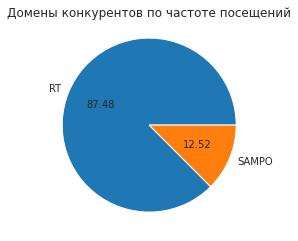

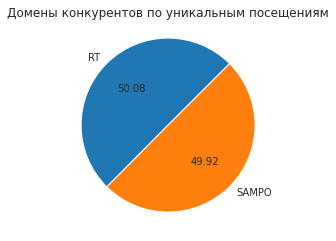


Пропущенных значений 0


In [ ]:
named_df.loc[named_df['url'].str.contains('sampo.', flags = re.I), 'domain'] = 'sampo'
named_df.loc[named_df['url'].str.contains('rt.', flags = re.I), 'domain'] = 'rt'

plt.pie(named_df['domain'].value_counts(), labels = ['RT', 'SAMPO'], autopct = '%.2f')
plt.title('Домены конкурентов по частоте посещений', y = 0.97)
plt.show()

plt.pie(named_df.groupby('domain')['contract_id'].nunique(), labels = ['RT', 'SAMPO'], 
         autopct = '%.2f', startangle = 45.0)
plt.title('Домены конкурентов по уникальным посещениям', y = 0.97)
plt.show()
print()
print('Пропущенных значений', named_df['domain'].isnull().sum())

***Столбец с разделением по дню недели  - рабочий или выходной.***

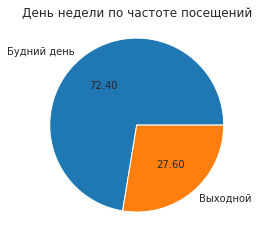


Пропущенных значений 0


In [ ]:
named_df['date'] = pd.to_datetime(named_df['date'])

named_df['weekday'] = named_df['date'].dt.weekday
named_df.loc[named_df['weekday'].isin([5, 6]), 'weekday'] = 'weekend'
named_df.loc[named_df['weekday'].isin([0, 1, 2, 3, 4]), 'weekday'] = 'working'

plt.pie(named_df['weekday'].value_counts(), labels = ['Будний день', 'Выходной'], autopct = '%.2f')
plt.title('День недели по частоте посещений', y = 0.97)
plt.show()
print()
print('Пропущенных значений', named_df['weekday'].isnull().sum())





***Формирование сводной таблицы по абонентам.***

In [ ]:
# Общее количество посещений и уникальные посещения.
visits_frequency = named_df.query("url!='camera.rt.ru'").groupby('contract_id', as_index = False)['url'].agg(['count', 'nunique'])\
                                                        .rename(columns = {'count': 'FrequencyOfVisits', 'nunique': 'UniqueVisitLinks'})

# Количество посещений в зависимости от домена - rt или sampo.
named_df['for_counting'] = 1
frequency_domain_visits = pd.pivot_table(named_df.query("url!='camera.rt.ru'"), index = 'contract_id', columns = ['domain'],
                                         values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()
summary_of_visits = visits_frequency.merge(frequency_domain_visits, on = 'contract_id')
summary_of_visits.rename(columns = {('for_counting', 'rt'): 'FreqOfRTVisits', 
                                    ('for_counting', 'sampo'): 'FreqOfSampoVisits'}, inplace = True)

# Количество уникальных url-адресов в зависимости от домена.
unique_rt_urls = named_df.query("domain=='rt'").groupby('contract_id', as_index = False)['url'].nunique()\
                         .rename(columns = {'url': 'UniqueRTLinks'})
summary_of_visits = summary_of_visits.merge(unique_rt_urls, how = 'left', on = 'contract_id')
summary_of_visits.fillna(0, inplace = True)
summary_of_visits['UniqueSAMPOLinks'] = abs(summary_of_visits['UniqueVisitLinks'] - summary_of_visits['UniqueRTLinks'])

# Какое количество дней абонент посещал домены конкурентов.
days_of_site_visits = named_df.groupby('contract_id', as_index = False)['date'].nunique()\
                              .rename(columns = {'date': 'VisitingDays'})
summary_of_visits = summary_of_visits.merge(days_of_site_visits, on = 'contract_id')

# Количество выходных и будних дней.
number_of_weekends = named_df.query("weekday=='weekend'").groupby('contract_id', as_index = False)['date'].nunique()\
                                 .rename(columns = {'date': 'VisitingWeekends'})

summary_of_visits = summary_of_visits.merge(number_of_weekends, how = 'left', on = 'contract_id')
summary_of_visits.fillna(0, inplace = True)
summary_of_visits['VisitingWorkingDays'] = abs(summary_of_visits['VisitingDays'] - summary_of_visits['VisitingWeekends'])

# Частота посещений в выходной или будний день.
frequency_weekday_visits = pd.pivot_table(named_df.query("url!='camera.rt.ru'"), index = 'contract_id', columns = ['weekday'],
                                          values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()
summary_of_visits = summary_of_visits.merge(frequency_weekday_visits, on = 'contract_id')
summary_of_visits.rename(columns = {('for_counting', 'working'): 'FreqOfWorkingDaysVisits',
                                    ('for_counting', 'weekend'): 'FreqOfWeekendVisits'}, inplace = True)

# Частота посещения rt.camera.
rt_camera_freq = named_df.query("url=='camera.rt.ru'").groupby('contract_id', as_index = False)['url'].count()\
                                                      .rename(columns = {'url': 'RTCameraFreq'})
summary_of_visits = summary_of_visits.merge(rt_camera_freq, how = 'left', on = 'contract_id')
summary_of_visits.fillna(0, inplace = True)

summary_of_visits.head()

,contract_id,FrequencyOfVisits,UniqueVisitLinks,FreqOfRTVisits,FreqOfSampoVisits,UniqueRTLinks,UniqueSAMPOLinks,VisitingDays,VisitingWeekends,VisitingWorkingDays,FreqOfWeekendVisits,FreqOfWorkingDaysVisits,RTCameraFreq
0,3455,24,10,5,19,4.0,6.0,9,3.0,6.0,7,17,0.0
1,3458,1,1,1,0,1.0,0.0,1,0.0,1.0,0,1,0.0
2,3459,2,2,1,1,1.0,1.0,1,0.0,1.0,0,2,0.0
3,3460,10,3,0,10,0.0,3.0,2,1.0,1.0,8,2,0.0
4,3461,1,1,1,0,1.0,0.0,1,1.0,0.0,1,0,0.0


In [ ]:
nn_quantiles = [summary_of_visits[i].quantile(0.99) for i in summary_of_visits.columns[1:]]

describe_df = summary_of_visits.describe().iloc[1:, 1:].T.round(2)
describe_df.insert(6, '99%', nn_quantiles)
describe_df

,mean,std,min,25%,50%,75%,99%,max
FrequencyOfVisits,16.89,37.04,1.0,14.0,16.0,19.0,27.0,6934.0
UniqueVisitLinks,13.69,3.49,1.0,12.0,14.0,16.0,22.0,71.0
FreqOfRTVisits,10.10,25.98,0.0,8.0,10.0,12.0,18.0,6922.0
FreqOfSampoVisits,6.80,26.13,0.0,5.0,6.0,8.0,13.0,6627.0
UniqueRTLinks,9.10,2.63,0.0,7.0,9.0,11.0,15.0,52.0
UniqueSAMPOLinks,4.59,2.26,0.0,3.0,4.0,6.0,10.0,70.0
VisitingDays,27.19,3.92,1.0,26.0,28.0,29.0,33.0,35.0
VisitingWeekends,7.65,1.57,0.0,7.0,8.0,9.0,10.0,10.0
VisitingWorkingDays,19.54,3.00,0.0,18.0,20.0,21.0,24.0,26.0
FreqOfWeekendVisits,4.60,11.44,0.0,3.0,4.0,6.0,10.0,2305.0


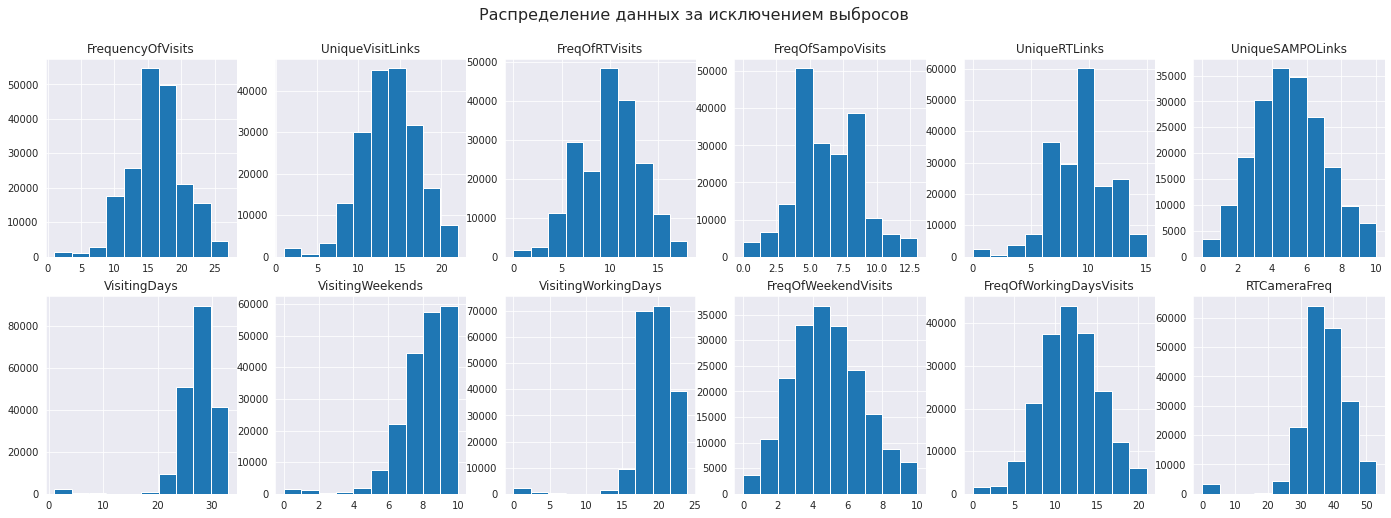

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (24, 8))
plt.suptitle('Распределение данных за исключением выбросов', fontsize = 16, y = 0.97)
for i in range(2):
  for j in range(6):
    ax = axes[i][j]
    if i == 0:
      feature = summary_of_visits.columns[1:][j]
      values = summary_of_visits.query(f'{feature}<={nn_quantiles[j]}')[feature]
      ax.hist(values)
      ax.set_title(feature)
    else:
      feature = summary_of_visits.columns[1:][j+6]
      values = summary_of_visits.query(f'{feature}<={nn_quantiles[j+6]}')[feature]
      ax.hist(values)
      ax.set_title(feature)

### Выборка тренировочных данных

In [ ]:
churn_and_visits = summary_of_visits.merge(train_df, how = 'right', on = 'contract_id')
churn_and_visits.isnull().sum()

contract_id                   0
FrequencyOfVisits          3077
UniqueVisitLinks           3077
FreqOfRTVisits             3077
FreqOfSampoVisits          3077
UniqueRTLinks              3077
UniqueSAMPOLinks           3077
VisitingDays               3077
VisitingWeekends           3077
VisitingWorkingDays        3077
FreqOfWeekendVisits        3077
FreqOfWorkingDaysVisits    3077
RTCameraFreq               3077
blocked                       0
dtype: int64

In [ ]:
churn_and_visits.fillna(0, inplace = True)

churn_and_visits['VisitsActivity'] = 1
churn_and_visits.loc[churn_and_visits.iloc[:, 1:-2].sum(axis = 1) == 0, 'VisitsActivity'] = 0

have_activity = churn_and_visits.query('VisitsActivity==1')
no_activity = churn_and_visits.query('VisitsActivity==0')

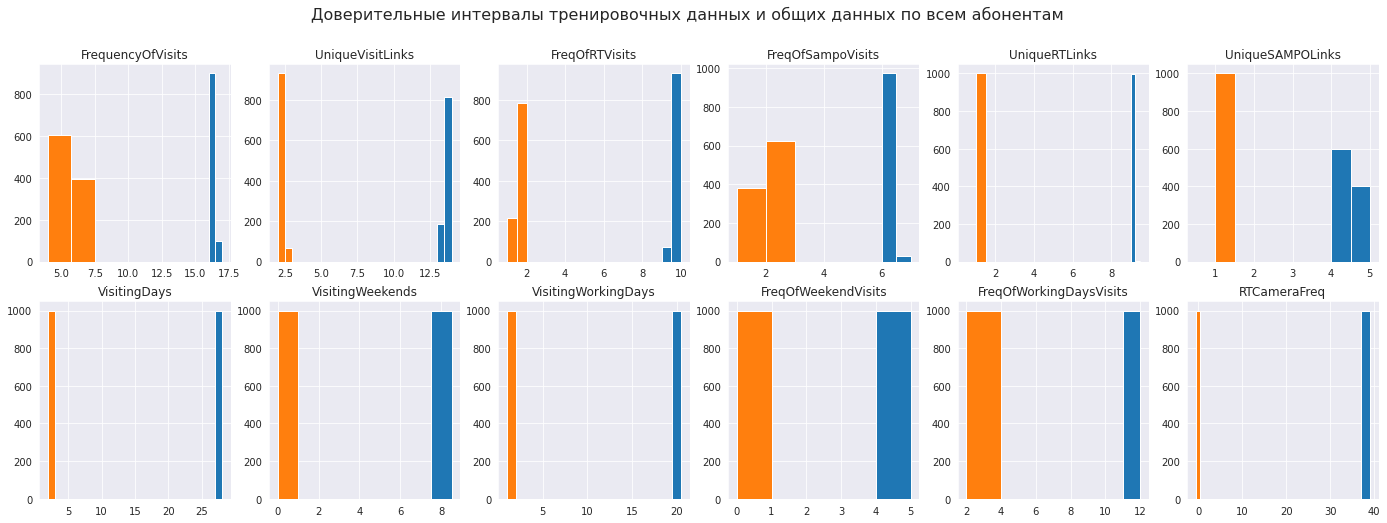

In [ ]:
general_population = []
selection = []
for col_index, column in enumerate(summary_of_visits.columns.to_list()[1:]):
  general_population.append([])
  selection.append([])
  for iteration in range(1000):
    general_array = np.random.choice(summary_of_visits[column], size = 500)
    selection_array = np.random.choice(have_activity[column], size = 500)
    general_population[col_index].append(np.median(general_array))
    selection[col_index].append(np.median(selection_array))

fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (24, 8))
plt.suptitle('Доверительные интервалы тренировочных данных и общих данных по всем абонентам', fontsize = 16, y = 0.98)
for i in range(2):
  for j in range(6):
    ax = axes[i][j]
    if i == 0:
      feature = summary_of_visits.columns[1:][j]
      ax.hist(general_population[j], bins = 2)
      ax.hist(selection[j], bins = 2)
      ax.set_title(feature)
    else:
      feature = summary_of_visits.columns[1:][j+6]
      ax.hist(general_population[j+6], bins = 1)
      ax.hist(selection[j+6], bins = 1)
      ax.set_title(feature)

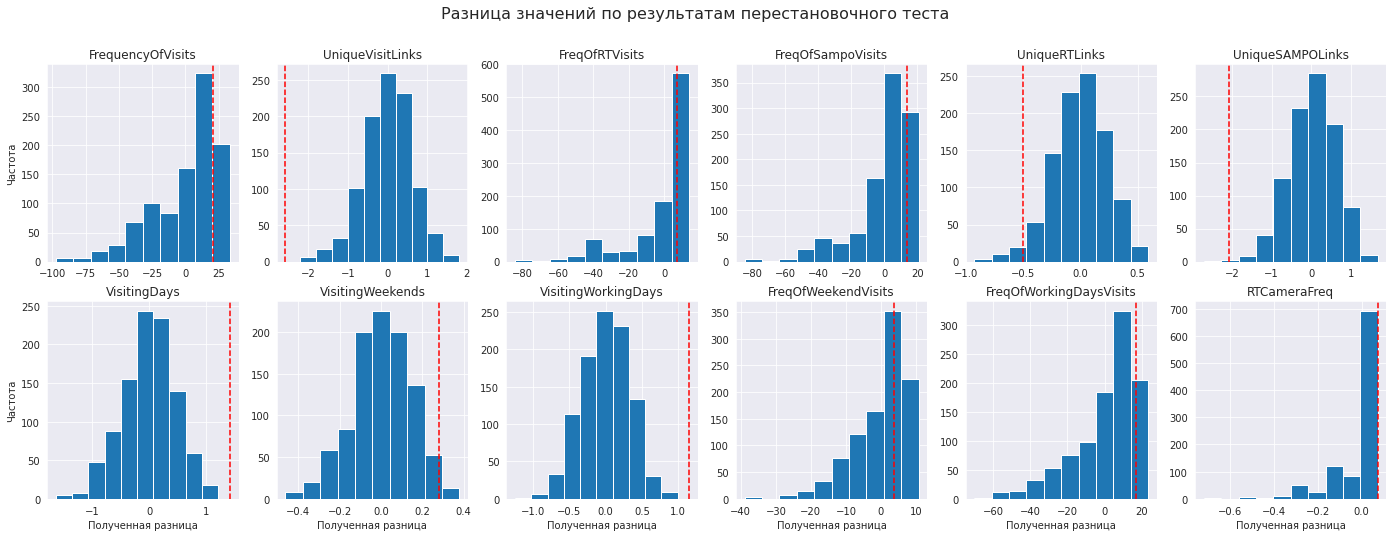

In [ ]:
blocked = have_activity.query('blocked==1')
no_blocked = have_activity.query('blocked==0')

columns = summary_of_visits.columns[1:]
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (24, 8))
plt.suptitle('Разница значений по результатам перестановочного теста', fontsize = 16, y = 0.98)
for i in range(2):
  for j in range(6):
    ax = axes[i][j]
    if i == 0:
      array_united = np.hstack([no_blocked[columns[j]], blocked[columns[j]]])
      mean_diff = no_blocked[columns[j]].mean() - blocked[columns[j]].mean()
      differences = []
      for iteration in range(1000):
        array_permutation = np.random.permutation(array_united)
        group_1 = array_permutation[:no_blocked.shape[0]]
        group_2 = array_permutation[no_blocked.shape[0]:]
        differences.append(np.mean(group_1) - np.mean(group_2))
      ax.hist(differences)
      ax.axvline(x = mean_diff, color = 'red', linestyle = '--')
      ax.set_title(columns[j])  
      if j == 0:    
        ax.set_ylabel('Частота')
    else:
      array_united = np.hstack([no_blocked[columns[j+6]], blocked[columns[j+6]]])
      mean_diff = no_blocked[columns[j+6]].mean() - blocked[columns[j+6]].mean()
      differences = []
      for iteration in range(1000):
        array_permutation = np.random.permutation(array_united)
        group_1 = array_permutation[:no_blocked.shape[0]]
        group_2 = array_permutation[no_blocked.shape[0]:]
        differences.append(np.mean(group_1) - np.mean(group_2))
      ax.hist(differences)
      ax.axvline(x = mean_diff, color = 'red', linestyle = '--')
      ax.set_title(columns[j+6])  
      ax.set_xlabel('Полученная разница')          
      if j == 0:    
        ax.set_ylabel('Частота')


***Интервалы между визитами на сайты, время до и после последнего визита***

In [ ]:
active_users_ids = have_activity['contract_id'].unique()

days_of_sites_visits = named_df[named_df['contract_id'].isin(active_users_ids)]\
                      .groupby(['contract_id', 'date'], as_index = False)['url'].nunique()

sorted_by_date = days_of_sites_visits.sort_values(['contract_id', 'date'])
intervals_between_visits = []
for user_id in sorted_by_date['contract_id'].unique():
  values = []
  for visit_number in range(1, sorted_by_date.query(f'contract_id=={user_id}').shape[0]):
    interval = (sorted_by_date.query(f'contract_id=={user_id}').iloc[visit_number, 1] - 
                sorted_by_date.query(f'contract_id=={user_id}').iloc[visit_number-1, 1]).days
    if interval != 0:
      values.append(interval)
  if len(values) == 0:
    mean_interval = 0
  else:
    mean_interval = round(sum(values) / len(values), 2)
  intervals_between_visits.append([user_id, mean_interval])

intervals_df = pd.DataFrame(intervals_between_visits, columns = ['contract_id', 'VisitsInterval'])
churn_and_visits = churn_and_visits.merge(intervals_df, how = 'left', on = 'contract_id').fillna(0)

days_before_and_after = []
max_date = named_df['date'].max()
for user_id in sorted_by_date['contract_id'].unique():
  first_visit = sorted_by_date.query(f'contract_id=={user_id}')['date'].to_list()[0]
  last_visit = sorted_by_date.query(f'contract_id=={user_id}')['date'].to_list()[-1]
  days_before_and_after.append([user_id, (max_date - first_visit).days, (max_date - last_visit).days,
                               (last_visit - first_visit).days])
periods_df = pd.DataFrame(days_before_and_after, columns = ['contract_id', 'DaysBeforeFirstVisit', 'DaysAfterLastVisit',
                                                            'PeriodOfActivity'])
churn_and_visits = churn_and_visits.merge(periods_df, how = 'left', on = 'contract_id').fillna(0)

churn_and_visits[['contract_id', 'DaysBeforeFirstVisit', 'DaysAfterLastVisit', 'PeriodOfActivity']].head(5)

,contract_id,DaysBeforeFirstVisit,DaysAfterLastVisit,PeriodOfActivity
0,7780,2.0,1.0,1.0
1,7785,27.0,8.0,19.0
2,7794,0.0,0.0,0.0
3,7795,0.0,0.0,0.0
4,7798,0.0,0.0,0.0


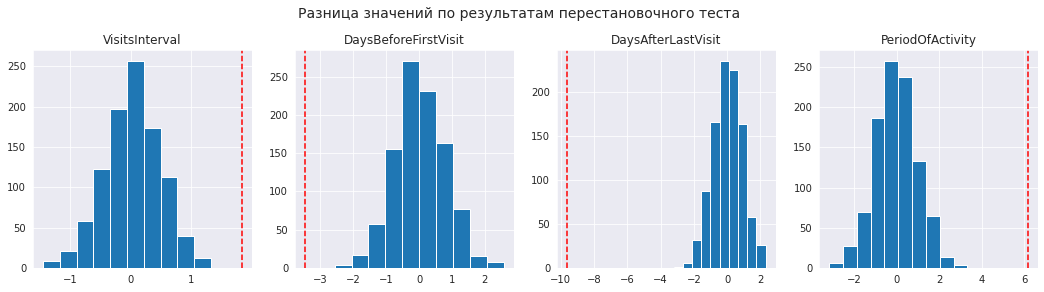

In [ ]:
blocked = churn_and_visits.query('blocked==1&VisitsActivity==1')
no_blocked = churn_and_visits.query('blocked==0&VisitsActivity==1')

columns = ['VisitsInterval', 'DaysBeforeFirstVisit', 'DaysAfterLastVisit', 'PeriodOfActivity']
fig, axes = plt.subplots(nrows = 1, ncols = 4, figsize = (18, 4))
plt.suptitle('Разница значений по результатам перестановочного теста', fontsize = 14, y = 1.03)
for i in range(4):
    ax = axes[i]
    array_united = np.hstack([no_blocked[columns[i]], blocked[columns[i]]])
    mean_diff = no_blocked[columns[i]].mean() - blocked[columns[i]].mean()
    differences = []
    for iteration in range(1000):
      array_permutation = np.random.permutation(array_united)
      group_1 = array_permutation[:no_blocked.shape[0]]
      group_2 = array_permutation[no_blocked.shape[0]:]
      differences.append(np.mean(group_1) - np.mean(group_2))
    ax.hist(differences)
    ax.axvline(x = mean_diff, color = 'red', linestyle = '--')
    ax.set_title(columns[i])  

In [ ]:
features_by_visits = churn_and_visits[['contract_id', 'FrequencyOfVisits', 'UniqueVisitLinks', 'UniqueSAMPOLinks', 'VisitingWeekends',
                                       'VisitingWorkingDays', 'VisitsInterval', 'DaysAfterLastVisit', 'PeriodOfActivity', 'VisitsActivity']]

## **Логи запросов к своему провайдеру**

### Обработка общих данных

In [ ]:
display(log_df.head(3))
print()
print()
print('Всего значений', log_df.shape[0])
print()
print('Пропущенные значения', log_df.isnull().sum())


,contract_id,event_date,event_type
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета




Всего значений 25274

Пропущенные значения contract_id    0
event_date     0
event_type     0
dtype: int64


In [ ]:
# Количество обращений по типу запроса.

log_df.groupby('event_type', as_index = False)['contract_id'].agg(['count', 'nunique'])\
      .sort_values('nunique', ascending = False).head(10)

,count,nunique
event_type,,
Информер ВК. Показ,8001,2715
Включение интернета на 20 минут,4092,1451
Обращение в службу заботы о клиентах,2860,1431
Гарантированный платеж за деньги,2679,925
Смена тарифа,335,310
Состояние клиентского оборудования,311,278
Включение интернета на 20 минут с IVR,343,256
Предложение ТВ,217,217
Оборудование,276,206


In [ ]:
# Самое первое и последнее обращения клиента.

first_event = log_df.sort_values(['contract_id', 'event_date']).groupby('contract_id', as_index = False)\
                                                               .first()[['contract_id', 'event_date', 'event_type']]
first_event['isFirstEvent'] = 1
log_df = log_df.merge(first_event, how = 'left', on = ['contract_id', 'event_date', 'event_type'])
log_df.fillna(0, inplace = True)

last_event = log_df.sort_values(['contract_id', 'event_date'], ascending = False)\
                    .groupby('contract_id', as_index = False).first()[['contract_id', 'event_date', 'event_type']]
last_event['isLastEvent'] = 1
log_df = log_df.merge(last_event, how = 'left', on = ['contract_id', 'event_date', 'event_type'])
log_df.fillna(0, inplace = True)

***Столбец с разделением по дню недели  - рабочий или выходной (+ время суток)***

In [ ]:
log_df['event_date'] = pd.to_datetime(log_df['event_date'])
log_df['weekday'] = log_df['event_date'].dt.weekday

log_df.loc[log_df['weekday'].isin([5, 6]), 'weekday'] = 'weekend'
log_df.loc[log_df['weekday'].isin([0, 1, 2, 3, 4]), 'weekday'] = 'working'

log_df['time'] = pd.to_datetime(log_df['event_date']).dt.time
log_df['time'] = log_df['time'].apply(lambda x: str(x))

log_df.loc[(log_df['time'] > '06:00:00') & (log_df['time'] <= '18:00:00'), 
           'RequestsTimeOfDay'] = 'first_half'
log_df.loc[(log_df['time'] > '18:00:00') & (log_df['time'] <= '23:59:59'), 
           'RequestsTimeOfDay'] = 'second_half'
log_df.loc[(log_df['time'] > '00:00:00') & (log_df['time'] <= '06:00:00'), 
           'RequestsTimeOfDay'] = 'second_half'           

log_df = log_df.drop('time', axis = 1)
display(log_df.head())
print()
print()
print('Пропущенные значения')
log_df['RequestsTimeOfDay'].isnull().sum()

,contract_id,event_date,event_type,isFirstEvent,isLastEvent,weekday,RequestsTimeOfDay
0,36294,2021-03-28 16:24:30,Добавление в Обращались с номеров,1.0,0.0,weekend,first_half
1,36294,2021-03-28 16:27:41,Обращение в службу заботы о клиентах,0.0,0.0,weekend,first_half
2,36294,2021-03-28 16:29:56,Выключение IPTV-пакета,0.0,0.0,weekend,first_half
3,36294,2021-03-28 16:29:56,Включение IPTV-пакета,0.0,0.0,weekend,first_half
4,36294,2021-03-28 16:35:04,Обращение в службу заботы о клиентах,0.0,0.0,weekend,first_half




Пропущенные значения


0

***Время между обращениями, а также время от первого и последнего обращения***

In [ ]:
log_df['event_date'] = log_df['event_date'].astype('datetime64[D]')
unique_dates = log_df.groupby(['contract_id', 'event_date'], as_index = False)['event_type'].nunique()
sorted_by_date = unique_dates.sort_values(['contract_id', 'event_date'])

In [ ]:
intervals_between_requests = []
for user_id in sorted_by_date['contract_id'].unique():
  values = []
  for request_number in range(1, sorted_by_date.query(f'contract_id=={user_id}').shape[0]):
    interval = (sorted_by_date.query(f'contract_id=={user_id}').iloc[request_number, 1] - 
                sorted_by_date.query(f'contract_id=={user_id}').iloc[request_number-1, 1]).days
    if interval != 0:
      values.append(interval)
  if len(values) == 0:
    mean_interval = 0
  else:
    mean_interval = round(sum(values) / len(values), 2)
  intervals_between_requests.append([user_id, mean_interval])

intervals_df = pd.DataFrame(intervals_between_requests, columns = ['contract_id', 'RequestsInterval'])

In [ ]:
days_before_first_event = log_df.query('isFirstEvent==1')
days_before_first_event['DaysBeforeFirstRequest'] = (log_df['event_date'].max() - days_before_first_event['event_date']).dt.days
days_before_first_event = days_before_first_event[['contract_id', 'DaysBeforeFirstRequest']]

days_after_last_event = log_df.query('isLastEvent==1')
days_after_last_event['DaysAfterLastRequest'] = (log_df['event_date'].max() - days_after_last_event['event_date']).dt.days
days_after_last_event = days_after_last_event[['contract_id', 'DaysAfterLastRequest']]

periods = []
for user_id in log_df['contract_id'].unique():
  first_date = sorted_by_date.query(f'contract_id=={user_id}')['event_date'].to_list()[0]
  last_date = sorted_by_date.query(f'contract_id=={user_id}')['event_date'].to_list()[-1]
  periods.append([user_id, (last_date - first_date).days])
periods_df = pd.DataFrame(periods, columns = ['contract_id', 'RequestPeriodsActivity'])

***Формирование сводной таблицы по клиентам***

In [ ]:
# Частота обращений и число уникальных обращений.
summary_of_requests = log_df.groupby('contract_id', as_index = False)['event_type'].agg(['count', 'nunique'])\
                            .rename(columns = {'count': 'FrequencyOfRequests', 'nunique': 'UniqueRequests'})

# Количество дней, когда клиент обращался с запросом.
request_days = log_df.groupby('contract_id', as_index = False)['event_date'].nunique()\
                     .rename(columns = {'event_date': 'RequestDays'})

summary_of_requests = summary_of_requests.merge(request_days, how = 'left', on = 'contract_id')

# Средний интервал между обращениями.
summary_of_requests = summary_of_requests.merge(intervals_df, how = 'left', on = 'contract_id')

# Количество дней с момента первого и последнего обращения
summary_of_requests = summary_of_requests.merge(days_before_first_event, how = 'left', on = 'contract_id')
summary_of_requests = summary_of_requests.merge(days_after_last_event, how = 'left', on = 'contract_id')

# Период активности клиента по запросам
summary_of_requests = summary_of_requests.merge(periods_df, how = 'left', on = 'contract_id')

# Количество выходных и будних дней.
weekdays_counts = log_df.query("weekday=='weekend'").groupby('contract_id', as_index = False)['event_date'].nunique()\
                        .rename(columns = {'event_date': 'RequestWeekends'})

summary_of_requests = summary_of_requests.merge(weekdays_counts, how = 'left', on = 'contract_id')
summary_of_requests.fillna(0, inplace = True)
summary_of_requests['RequestWorkingDays'] = abs(summary_of_requests['RequestDays'] - summary_of_requests['RequestWeekends'])

# Частота обращений в рабочие и выходные дни.
log_df['for_counting'] = 1

requests_by_weekdays = pd.pivot_table(log_df, index = 'contract_id', columns = ['weekday'],
                                  values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()

summary_of_requests = summary_of_requests.merge(requests_by_weekdays, how = 'left', on = 'contract_id')
summary_of_requests.rename(columns = {('for_counting', 'weekend'): 'FreqOfWeekendRequests', 
                                     ('for_counting', 'working'): 'FreqOfWorkingDayRequests'}, inplace = True)

# Частота обращений по времени суток.
requests_by_timeOfDay = pd.pivot_table(log_df, index = 'contract_id', columns = ['RequestsTimeOfDay'],
                                       values = ['for_counting'], aggfunc = np.sum, fill_value = 0).reset_index()

summary_of_requests = summary_of_requests.merge(requests_by_timeOfDay, how = 'left', on = 'contract_id')
summary_of_requests.rename(columns = {('for_counting', 'first_half'): 'RequestsFirstHalf', 
                                      ('for_counting', 'second_half'): 'RequestsSecondHalf'}, inplace = True)

summary_of_requests.head()

,contract_id,FrequencyOfRequests,UniqueRequests,RequestDays,RequestsInterval,DaysBeforeFirstRequest,DaysAfterLastRequest,RequestPeriodsActivity,RequestWeekends,RequestWorkingDays,FreqOfWeekendRequests,FreqOfWorkingDayRequests,RequestsFirstHalf,RequestsSecondHalf
0,3453,1,1,1,0.00,57,57,0,0.0,1.0,0,1,1,0
1,3454,1,1,1,0.00,1,1,0,0.0,1.0,0,1,1,0
2,3456,4,4,1,0.00,39,39,0,1.0,0.0,4,0,0,4
3,3457,4,1,4,17.00,51,0,51,1.0,3.0,1,3,1,3
4,3458,23,2,20,3.11,59,0,59,5.0,15.0,6,17,11,12


In [ ]:
nn_quantiles = [summary_of_requests[i].quantile(0.99) for i in summary_of_requests.columns[1:]]

describe_df = summary_of_requests.describe().iloc[1:, 1:].T.round(2)
describe_df.insert(6, '99%', nn_quantiles)
describe_df

,mean,std,min,25%,50%,75%,99%,max
FrequencyOfRequests,5.86,9.24,1.0,2.0,4.0,7.00,30.0,354.0
UniqueRequests,2.69,2.21,1.0,1.0,2.0,3.00,11.0,17.0
RequestDays,3.35,3.91,1.0,1.0,2.0,4.00,20.0,59.0
RequestsInterval,8.75,10.46,0.0,0.0,5.4,13.33,42.0,58.0
DaysBeforeFirstRequest,40.43,15.87,0.0,31.0,44.0,54.00,59.0,59.0
DaysAfterLastRequest,20.18,16.27,0.0,6.0,17.0,31.00,58.0,59.0
RequestPeriodsActivity,20.25,19.81,0.0,0.0,17.0,37.00,58.0,59.0
RequestWeekends,0.87,1.24,0.0,0.0,1.0,1.00,6.0,15.0
RequestWorkingDays,2.48,3.04,0.0,1.0,2.0,3.00,15.0,44.0
FreqOfWeekendRequests,1.53,3.02,0.0,0.0,1.0,2.00,10.0,104.0


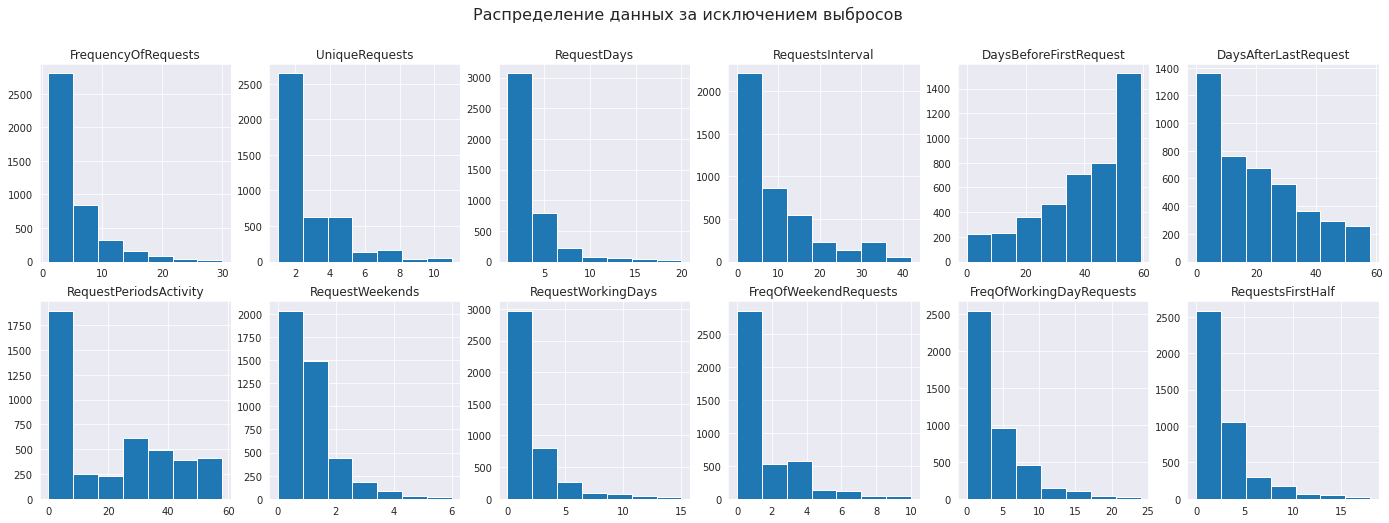

In [ ]:
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (24, 8))
plt.suptitle('Распределение данных за исключением выбросов', fontsize = 16, y = 0.98)
for i in range(2):
  for j in range(6):
    ax = axes[i][j]
    if i == 0:
      feature = summary_of_requests.columns[1:][j]
      values = summary_of_requests.query(f'{feature}<={nn_quantiles[j]}')[feature]
      ax.hist(values, bins = 7)
      ax.set_title(feature)
    else:
      feature = summary_of_requests.columns[1:][j+6]
      values = summary_of_requests.query(f'{feature}<={nn_quantiles[j+6]}')[feature]
      ax.hist(values, bins = 7)
      ax.set_title(feature)

### Выборка тренировочный данных

In [ ]:
churn_and_requests = summary_of_requests.merge(train_df, how = 'right', on = 'contract_id')
churn_and_requests.isnull().sum()

contract_id                    0
FrequencyOfRequests         2183
UniqueRequests              2183
RequestDays                 2183
RequestsInterval            2183
DaysBeforeFirstRequest      2183
DaysAfterLastRequest        2183
RequestPeriodsActivity      2183
RequestWeekends             2183
RequestWorkingDays          2183
FreqOfWeekendRequests       2183
FreqOfWorkingDayRequests    2183
RequestsFirstHalf           2183
RequestsSecondHalf          2183
blocked                        0
dtype: int64

In [ ]:
churn_and_requests.fillna(0, inplace = True)

churn_and_requests['RequestsActivity'] = 0
churn_and_requests.loc[churn_and_requests.iloc[:, 1:-2].sum(axis = 1) > 0, 'RequestsActivity'] = 1

have_activity = churn_and_requests.query('RequestsActivity==1')
no_activity = churn_and_requests.query('RequestsActivity==0')

blocked = have_activity.query('blocked==1')
no_blocked = have_activity.query('blocked==0')

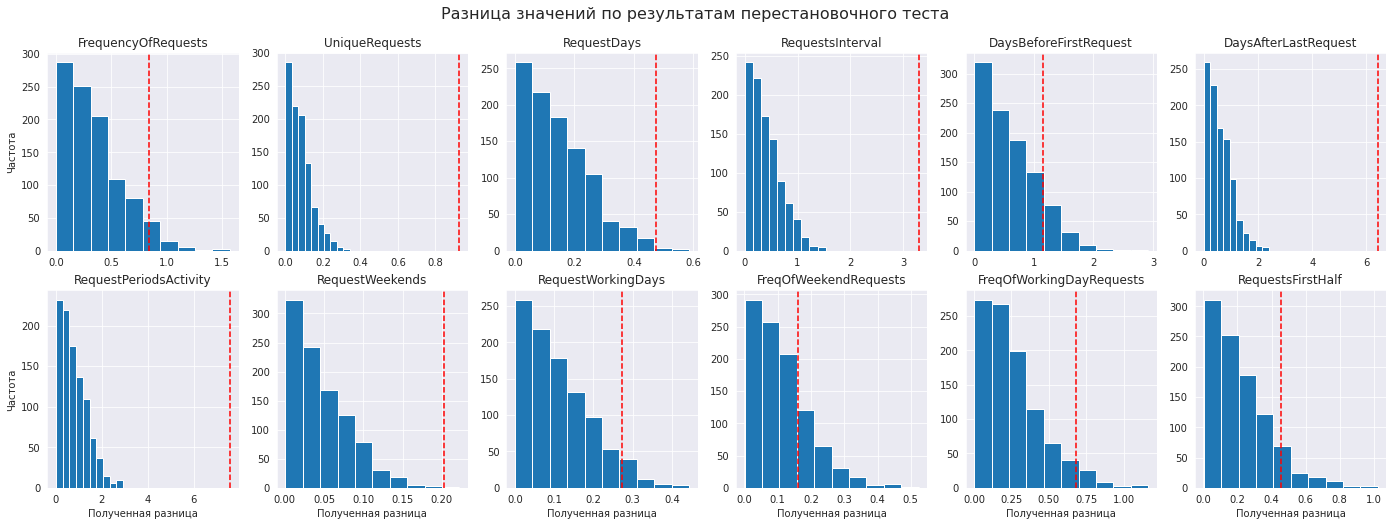

In [ ]:
columns = summary_of_requests.columns[1:]
fig, axes = plt.subplots(nrows = 2, ncols = 6, figsize = (24, 8))
plt.suptitle('Разница значений по результатам перестановочного теста', fontsize = 16, y = 0.96)
for i in range(2):
  for j in range(6):
    ax = axes[i][j]
    if i == 0:
      array_united = np.hstack([no_blocked[columns[j]], blocked[columns[j]]])
      mean_diff = abs(no_blocked[columns[j]].mean() - blocked[columns[j]].mean())
      differences = []
      for iteration in range(1000):
        array_permutation = np.random.permutation(array_united)
        group_1 = array_permutation[:no_blocked.shape[0]]
        group_2 = array_permutation[no_blocked.shape[0]:]
        differences.append(abs(np.mean(group_1) - np.mean(group_2)))
      ax.hist(differences)
      ax.axvline(x = mean_diff, color = 'red', linestyle = '--')
      ax.set_title(columns[j])  
      if j == 0:    
        ax.set_ylabel('Частота')
    else:
      array_united = np.hstack([no_blocked[columns[j+6]], blocked[columns[j+6]]])
      mean_diff = abs(no_blocked[columns[j+6]].mean() - blocked[columns[j+6]].mean())
      differences = []
      for iteration in range(1000):
        array_permutation = np.random.permutation(array_united)
        group_1 = array_permutation[:no_blocked.shape[0]]
        group_2 = array_permutation[no_blocked.shape[0]:]
        differences.append(abs(np.mean(group_1) - np.mean(group_2)))
      ax.hist(differences)
      ax.axvline(x = mean_diff, color = 'red', linestyle = '--')
      ax.set_title(columns[j+6])  
      ax.set_xlabel('Полученная разница')          
      if j == 0:    
        ax.set_ylabel('Частота')


In [ ]:
features_by_requests = churn_and_requests[['contract_id', 'FrequencyOfRequests', 'UniqueRequests', 'RequestsInterval', 
                                           'RequestPeriodsActivity', 'DaysAfterLastRequest', 'RequestsActivity']]

## **Объединение данных в общей таблице**

In [ ]:
general_table = pd.merge(features_by_visits, features_by_requests, on = 'contract_id')
general_table = general_table.merge(contract_df, how = 'left', on = 'contract_id').fillna(0)
general_table = general_table.merge(train_df, on = 'contract_id').drop_duplicates()
general_table.isnull().sum()

contract_id               0
FrequencyOfVisits         0
UniqueVisitLinks          0
UniqueSAMPOLinks          0
VisitingWeekends          0
VisitingWorkingDays       0
VisitsInterval            0
DaysAfterLastVisit        0
PeriodOfActivity          0
VisitsActivity            0
FrequencyOfRequests       0
UniqueRequests            0
RequestsInterval          0
RequestPeriodsActivity    0
DaysAfterLastRequest      0
RequestsActivity          0
day_or_month_contract     0
blocked                   0
dtype: int64

**Сводная информация по данным о пользователях и оттоку**

In [ ]:
general_table.groupby(['VisitsActivity', 'RequestsActivity',])['blocked'].agg(['count', 'mean'])

count      mean
VisitsActivity RequestsActivity                 
0              0                  1236  0.111650
               1                  1841  0.218903
1              0                   947  0.024287
               1                  1968  0.068089

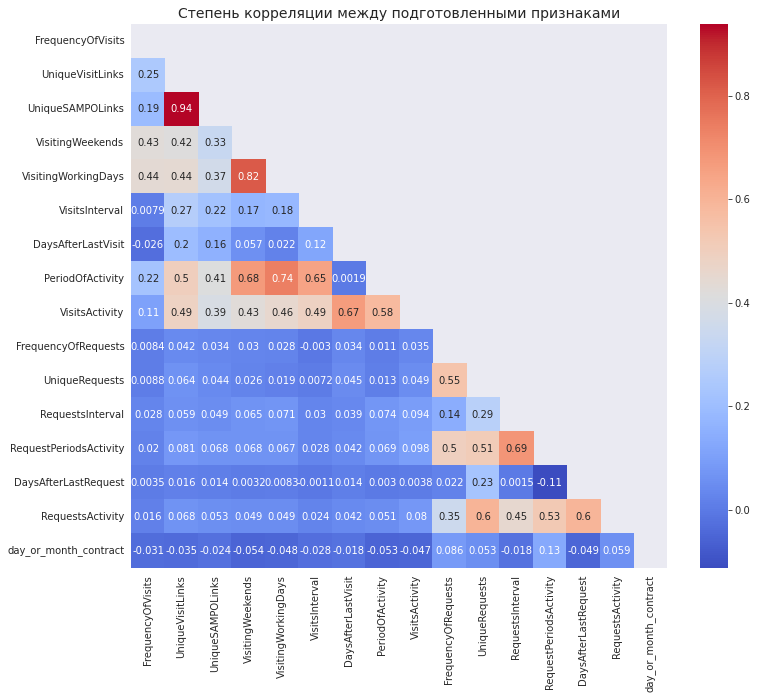

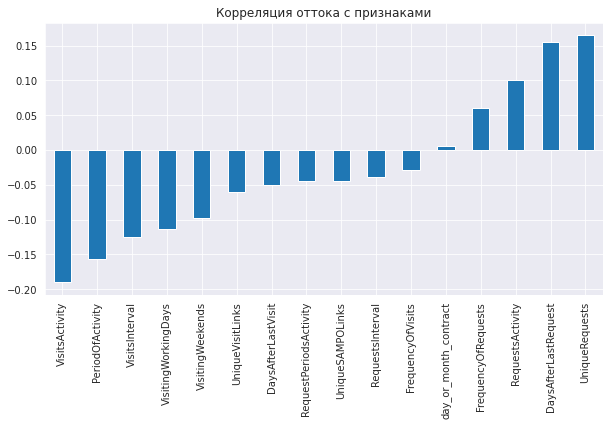

In [ ]:
plt.figure(figsize = (12, 10))
all_features = general_table.drop(['contract_id', 'blocked'], axis = 1)
matrix = np.triu(all_features.corr())
sns.heatmap(all_features.corr(), annot = True, mask = matrix, cmap = 'coolwarm')
plt.title('Степень корреляции между подготовленными признаками', fontsize = 14)
plt.show()

plt.figure(figsize = (10, 5))
general_table.corr()['blocked'][1:].drop('blocked', axis = 0).sort_values().plot(kind = 'bar')
plt.title('Корреляция оттока с признаками')
plt.show()

In [ ]:
general_table = general_table.drop(['day_or_month_contract', 'UniqueSAMPOLinks', 'VisitingWorkingDays'], axis = 1)

## **Выбор модели и запуск алгоритма**

In [ ]:
from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (roc_auc_score, f1_score, recall_score, 
                             confusion_matrix, accuracy_score)


In [ ]:
def plot_confusion_matrix_illustration(conf_matrix, model_name):
    plt.figure(figsize = (6, 6))
    confusion = conf_matrix
    plt.title(f'Матрица ошибок для {model_name}', fontsize = 18, y = 1.05)
    plt.text(0.40, 0.7, confusion[0, 0], size = 50, horizontalalignment = 'right')
    plt.text(0.40, 0.2, confusion[1, 0], size = 50, horizontalalignment = 'right')
    plt.text(0.90, 0.7, confusion[0, 1], size = 50, horizontalalignment = 'right')
    plt.text(0.90, 0.2, confusion[1, 1], size = 50, horizontalalignment = 'right')
    plt.xticks([0.25, 0.75], ['predicted "not churn"', 'predicted "churn"'], size = 15)
    plt.yticks([0.25, 0.75], ['true "churn"', 'true "not churn"'], size = 15)
    plt.plot([0.5, 0.5], [0, 1], '--', c = 'k')
    plt.plot([0, 1], [0.5, 0.5], '--', c = 'k')

    plt.xlim(0, 1)
    plt.ylim(0, 1)

In [ ]:
features = general_table.drop(['contract_id', 'blocked'], axis = 1)
targets = general_table['blocked']

scaler_grid = MinMaxScaler()
scaler_grid.fit(features)
features_scaled = scaler_grid.transform(features)

In [ ]:
skf = StratifiedKFold(n_splits = 5, random_state = 17, shuffle = True)
lrg = LogisticRegression(random_state = 17, max_iter = 1000)
lrg_params = {'solver': ['liblinear'], 'penalty': ['l1', 'l2'], 'C': np.arange(0.1, 1, 0.1),
              'class_weight': [{1 : i} for i in range(4, 8)]}
grid = GridSearchCV(lrg, lrg_params, cv = skf, scoring = 'recall_macro')
model = grid.fit(features_scaled, targets)

In [ ]:
model.best_params_

{'C': 0.7000000000000001,
 'class_weight': {1: 7},
 'penalty': 'l1',
 'solver': 'liblinear'}

LogisticRegression
***********************************
Правильность на обучающем наборе: 0.7448
f1_score: 37.5153
ROC_AUC: 70.6961
ROC_AUC_proba: 78.3934
Recall_score: 70.7




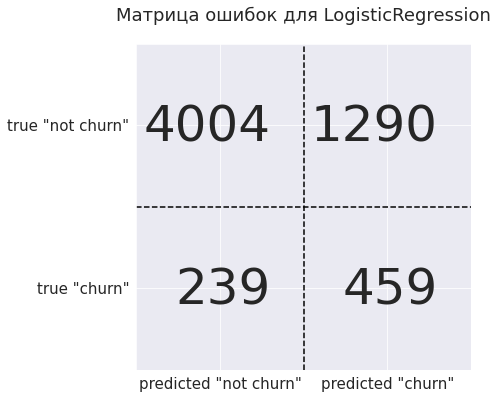

In [ ]:
lrg = LogisticRegression(solver = 'liblinear', penalty = 'l1', C = 0.7, class_weight = {1: 7}, random_state = 17, max_iter = 1000)
lrg_model = lrg.fit(features_scaled, targets)
lrg_predict = lrg_model.predict(features_scaled)
lrg_predict_proba = lrg_model.predict_proba(features_scaled)[:, 1]
recall_train = recall_score(targets, lrg_model.predict(features_scaled), average = 'macro')
recall = recall_score(targets, lrg_predict, average = 'macro')

print('LogisticRegression')
print('*' * 35)
print(f'Правильность на обучающем наборе: {round(lrg_model.score(features_scaled, targets), 4)}')
print(f'f1_score: {round(f1_score(targets, lrg_predict)*100, 4)}')
print(f'ROC_AUC: {round(roc_auc_score(targets, lrg_predict)*100, 4)}')
print(f'ROC_AUC_proba: {round(roc_auc_score(targets, lrg_predict_proba)*100, 4)}')
print(f'Recall_score: {round(recall * 100, 2)}')
print()
print()
plot_confusion_matrix_illustration(confusion_matrix(targets, lrg_predict), 'LogisticRegression')

In [ ]:
predictions = features.copy()
predictions['true'] = targets
predictions['predict'] = lrg_predict
predictions['proba'] = lrg_predict_proba
predictions.loc[(predictions['true'] == 0) & (predictions['predict'] == 1), 'FP'] = 1
predictions.loc[(predictions['true'] == 1) & (predictions['predict'] == 0), 'FN'] = 1
predictions.loc[(predictions['true'] == 1) & (predictions['predict'] == 1), 'TP'] = 1
predictions.loc[(predictions['true'] == 0) & (predictions['predict'] == 0), 'TN'] = 1
predictions.fillna(0, inplace = True)
predictions.groupby(['RequestsActivity', 'VisitsActivity'], as_index = False)[['FP', 'FN', 'TP', 'TN']].sum()

,RequestsActivity,VisitsActivity,FP,FN,TP,TN
0,0,0,0.0,138.0,0.0,1098.0
1,0,1,12.0,17.0,6.0,912.0
2,1,0,1044.0,22.0,381.0,394.0
3,1,1,234.0,62.0,72.0,1600.0


# Контрольная проверка

In [ ]:
control_df = pd.read_csv('/content/drive/MyDrive/Датасеты/sample_solution.csv')

In [ ]:
visits = summary_of_visits.merge(control_df, how = 'right', on = 'contract_id')
visits.fillna(0, inplace = True)
visits['VisitsActivity'] = 1
visits.loc[visits.iloc[:, 1:-2].sum(axis = 1) == 0, 'VisitsActivity'] = 0

active_users_ids = visits.query('VisitsActivity==1')['contract_id'].unique()
days_of_sites_visits = named_df[named_df['contract_id'].isin(active_users_ids)]\
                      .groupby(['contract_id', 'date'], as_index = False)['url'].nunique()
sorted_by_date = days_of_sites_visits.sort_values(['contract_id', 'date'])
intervals_between_visits = []
for user_id in sorted_by_date['contract_id'].unique():
  values = []
  for visit_number in range(1, sorted_by_date.query(f'contract_id=={user_id}').shape[0]):
    interval = (sorted_by_date.query(f'contract_id=={user_id}').iloc[visit_number, 1] - 
                sorted_by_date.query(f'contract_id=={user_id}').iloc[visit_number-1, 1]).days
    if interval != 0:
      values.append(interval)
  if len(values) == 0:
    mean_interval = 0
  else:
    mean_interval = round(sum(values) / len(values), 2)
  intervals_between_visits.append([user_id, mean_interval])
intervals_df = pd.DataFrame(intervals_between_visits, columns = ['contract_id', 'VisitsInterval'])
visits = visits.merge(intervals_df, how = 'left', on = 'contract_id').fillna(0)

days_before_and_after = []
max_date = named_df['date'].max()
for user_id in sorted_by_date['contract_id'].unique():
  first_visit = sorted_by_date.query(f'contract_id=={user_id}')['date'].to_list()[0]
  last_visit = sorted_by_date.query(f'contract_id=={user_id}')['date'].to_list()[-1]
  days_before_and_after.append([user_id, (max_date - first_visit).days, (max_date - last_visit).days,
                               (last_visit - first_visit).days])
periods_df = pd.DataFrame(days_before_and_after, columns = ['contract_id', 'DaysBeforeFirstVisit', 'DaysAfterLastVisit',
                                                            'PeriodOfActivity'])
visits = visits.merge(periods_df, how = 'left', on = 'contract_id').fillna(0)

final_visits = visits[['contract_id', 'FrequencyOfVisits', 'UniqueVisitLinks', 'UniqueSAMPOLinks', 'VisitingWeekends',
                       'VisitingWorkingDays', 'VisitsInterval', 'DaysAfterLastVisit', 'PeriodOfActivity', 'VisitsActivity']]



requests = summary_of_requests.merge(control_df, how = 'right', on = 'contract_id')
requests.fillna(0, inplace = True)
requests['RequestsActivity'] = 1
requests.loc[requests.iloc[:, 1:-2].sum(axis = 1) == 0, 'RequestsActivity'] = 0
requests_final = requests[['contract_id', 'FrequencyOfRequests', 'UniqueRequests', 'RequestsInterval', 
                           'RequestPeriodsActivity', 'DaysAfterLastRequest', 'RequestsActivity']]

final_table = pd.merge(final_visits, requests_final, on = 'contract_id')
final_table = final_table.merge(contract_df, how = 'left', on = 'contract_id').fillna(0)
final_table = final_table.merge(control_df, on = 'contract_id').drop_duplicates()

final_table = final_table.drop(['day_or_month_contract', 'UniqueSAMPOLinks', 'VisitingWorkingDays'], axis = 1)

In [ ]:
control_features = final_table.drop(['contract_id', 'blocked'], axis = 1)
control_features = scaler_grid.transform(control_features)
control_predict = model.predict(control_features)

In [ ]:
predictions = pd.DataFrame({'contract_id': control_df['contract_id'].values,
                            'blocked': control_predict})

predictions.to_csv('...', index = False)